# Classification of Apoptotic cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

In vivo identification of apoptotic and extracellular vesicle-bound live cells using image-based deep learning https://doi.org/10.1080%2F20013078.2020.1792683


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

2023-10-31 09:08:12.762341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 09:08:19.852899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

In [5]:
from joblib import Parallel, delayed
import h5py

def list_of_dict_to_dict(list_of_dicts):
    new_dict = dict()
    for one_dict in list_of_dicts:
        new_dict.update(one_dict)
    return new_dict


def get_label(h5_file_path):
    h5_file = h5py.File(h5_file_path, "r")
    ## label
    results = dict()
    try:
        results["label"] = h5_file.get("label")[()]
        results["set"] = "labeled"
    except TypeError:
        results["label"] = "-1"
        results["set"] = "unlabeled"
    try:
        results["object_number"] = os.path.split(h5_file_path)[-1]
        results["object_number"] = results["object_number"].replace(".h5", "")
        results["object_number"] = results["object_number"].split("_")[-1]
    except TypeError:
        results["object_number"] = None
    h5_file.close()
    return results

def metadata_generator(data_dir, sample_size=None, n_jobs=-1):

    metadata_columns = ["file",
                        "experiment",
                        "donor",
                        "condition",
                        "object_number",
                        "set",
                        "label"]
    metadata = pd.DataFrame(columns=metadata_columns)

    experiments_list = sorted(os.listdir(data_dir))
    print("Metadata prepration starts...")
    for exp in experiments_list:
        experiments_path = os.path.join(data_dir, exp)
        donors_list = sorted(os.listdir(experiments_path))
        for donor in donors_list:
            donors_path = os.path.join(data_dir, exp, donor)
            conditions_list = sorted(os.listdir(donors_path))
            for cond in conditions_list:
                print(exp, donor, cond)
                conditions_path = os.path.join(data_dir, exp, donor, cond + "/*.h5")
                files = glob.glob(conditions_path)

                if sample_size:
                    files = random.choices(files, k=min(sample_size, len(files)))

                metadata_temp = pd.DataFrame(columns=metadata_columns)
                metadata_temp["file"] = files
                metadata_temp["experiment"] = exp
                metadata_temp["donor"] = donor
                metadata_temp["condition"] = cond

                index_list = metadata_temp.file.tolist()

                # data parallelism
                results = Parallel(n_jobs=n_jobs)(delayed(get_label)(f) \
                            for f in tqdm(index_list, position=0, leave=True) )
                results = pd.DataFrame(results)

                if results.shape[0] > 0:
                    metadata_temp["label"] = results["label"]
                    metadata_temp["set"] = results["set"]
                    metadata_temp["object_number"] = results["object_number"]

                    metadata = pd.concat([metadata, metadata_temp], ignore_index=True)
                results = None
                metadata_temp = None
    print("...metadata prepration ended.")
    return metadata

now lets calculate the metadata:

In [6]:
%%time

data_path = "/projects/site/pred/data_science/year/2022/Apoptotic_cell_detection/"
metadata = metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 15311/15311 [00:03<00:00, 5089.71it/s] 


...metadata prepration ended.
CPU times: user 1.94 s, sys: 1.78 s, total: 3.72 s
Wall time: 3.79 s


In [7]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,822,labeled,b'apoptotic'
1,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,12187,labeled,b'non-apoptotic'
2,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,2295,labeled,b'apoptotic'
3,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,14306,labeled,b'non-apoptotic'
4,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,2584,labeled,b'apoptotic'
...,...,...,...,...,...,...,...
15306,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,10365,labeled,b'apoptotic'
15307,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,2952,labeled,b'apoptotic'
15308,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,7308,labeled,b'non-apoptotic'
15309,/projects/site/pred/data_science/year/2022/Apo...,Experiment_1,Donor_1,condition_1,3211,labeled,b'apoptotic'


[b'apoptotic' b'non-apoptotic']


<Axes: >

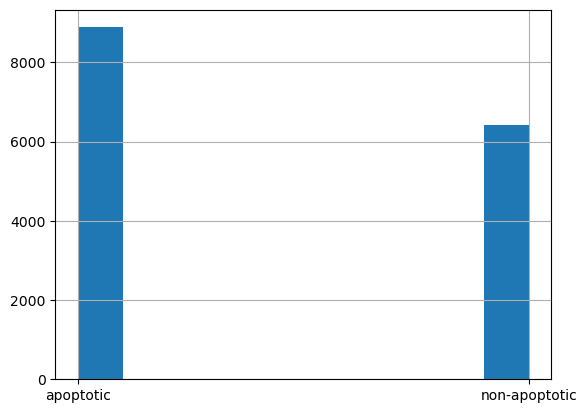

In [8]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [9]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)
metadata.label = [lbl.decode("utf-8") for lbl in metadata.label]

lets plot a random image per class

apoptotic
non-apoptotic


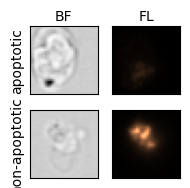

In [10]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (2,2),
                    channel_colors =  ["Greys", "copper"],
                          channels = ["BF","FL"],
                    image_size = 32)


Set all random seeds to the specific value, so the results are more reproducable

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [12]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 32


In [13]:
batch_size = 128
num_workers = 4
device="cuda"

In [14]:
channel_importance = pd.read_csv("channel_importance.csv")

In [15]:
from sklearn.preprocessing import MinMaxScaler
interpretation_methods = ["PXPermute", "Occlusion", "GuidedGradCAM", "DeepLift", "IntegratedGradients", "LRP"]
channel_importance.loc[:, interpretation_methods] = MinMaxScaler().fit_transform(channel_importance.loc[:, interpretation_methods])

channel_importance

,fold,channel,PXPermute,DeepLift,IntegratedGradients,LRP,GuidedGradCAM,Occlusion
0,1,Ch0,0.020825,0.285036,0.403507,0.386061,0.149481,0.157249
1,1,Ch1,0.871877,0.072480,0.123839,0.186646,0.113056,0.549806
2,2,Ch0,0.000000,0.188723,0.205963,0.250545,0.147942,0.070168
3,2,Ch1,0.849714,0.029331,0.063776,0.203279,0.153033,0.502121
4,3,Ch0,0.030804,0.433597,0.419174,1.000000,0.172053,0.017330
5,3,Ch1,1.000000,0.054088,0.192990,0.183858,0.999939,0.484513
6,4,Ch0,0.016723,0.280221,0.287902,0.150971,0.153946,0.003313
7,4,Ch1,0.907170,0.006514,0.071697,0.206344,0.149948,0.543929
8,5,Ch0,0.012103,0.994966,1.000000,0.334631,0.148845,0.536099
9,5,Ch1,0.876517,0.000000,0.021124,0.229263,0.148958,0.548660


<Axes: xlabel='variable', ylabel='value'>

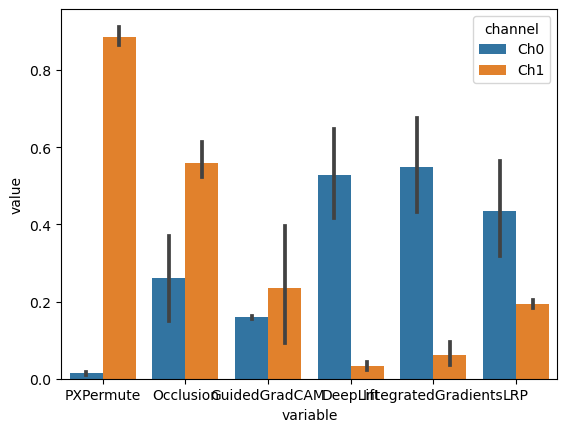

In [16]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            order = interpretation_methods,
            hue = "channel")

<Axes: ylabel='channel'>

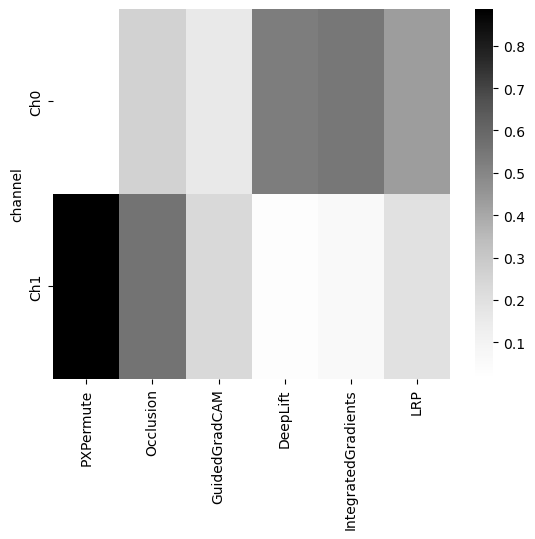

In [17]:
sns.heatmap(channel_importance.groupby(["channel"]).mean().loc[:,interpretation_methods], cmap = "Greys")

In [18]:
def select_top_channels(channel_importance, method, num_top_channels):
    grouped_importance = channel_importance.loc[:,["channel",method]].groupby("channel").mean()
    grouped_importance = grouped_importance.sort_values(by=method, ascending = False) 
    selected_channels = grouped_importance.index[:num_top_channels]
    selected_channels = [int(ch.replace("Ch","")) for ch in selected_channels]
    return selected_channels

In [19]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [20]:
def get_statistics(dataloader, selected_channels, device="cuda"):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels).to(device)
    statistics["p99"] = torch.zeros(nmb_channels).to(device)
    for data_l in dataloader:
        image, _ = data_l
        image = image.to(device)
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))
        statistics[k] = statistics[k].to("cpu")

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [21]:
set_of_interesting_classes = metadata.label.unique().tolist()
label_map = dict(zip(sorted(set(set_of_interesting_classes)), np.arange(len(set(set_of_interesting_classes)))))

In [22]:
%%time

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

num_all_channels = len(channel_importance.channel.unique())



results_with_best_channels = pd.DataFrame(columns = ["method",
                                                     "f1_micro",
                                                     "f1_macro",
                                                     "accuracy",
                                                    "fold_num"] + channel_importance.channel.unique().tolist())


for met in interpretation_methods:
    for num_top_channels in reversed((range(1,num_all_channels+1))):
        selected_channels = select_top_channels(channel_importance, met , num_top_channels)
        selected_channels.sort()
        print(met, selected_channels)
        train_index, test_index, _, _ = train_test_split(metadata.index, 
                                                        metadata.label.tolist(), 
                                                        stratify = metadata.label.tolist(),
                                                        test_size=0.2, 
                                                        shuffle=True,
                                                        random_state=seed_value)
        skf = StratifiedKFold(n_splits=5,shuffle=False)
        fold_num = 1
        for train_index, validation_index in skf.split(train_index.tolist(), 
                                metadata.loc[train_index, "label"].replace(label_map)):

            print("sizes: train", len(train_index), 
                  "validation", len(validation_index), 
                  "sizes: test", len(test_index))


            train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                         label_map=label_map,
                                         selected_channels=selected_channels,
                                         scaling_factor=scaling_factor,
                                         reshape_size=reshape_size,
                                         transform=transforms.Compose([ ] ))
            train_loader = DataLoader(train_dataset, 
                                      batch_size=batch_size,
                                      shuffle=False,
                                      num_workers=num_workers,
                                      pin_memory=True)
            statistics = get_statistics(train_loader, selected_channels=selected_channels)
            train_loader = None

            stats = dict()
            stats["lower_bound"] = statistics['p01']
            stats["upper_bound"] = statistics['p99']

            train_transform = [ 
                        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                                max_in =  stats["upper_bound"] , 
                                                min_out =  0. , 
                                                max_out =  1.),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        AddGaussianNoise(mean=0., std=0.01),
                ]

            validation_transform =  [ 
                        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                                max_in =  stats["upper_bound"] , 
                                                min_out =  0. , 
                                                max_out =  1.),
                ]

            test_transform =  [ 
                        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                                max_in =  stats["upper_bound"] , 
                                                min_out =  0. , 
                                                max_out =  1.),
                ]


            train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                         label_map=label_map,
                                         selected_channels=selected_channels,
                                         scaling_factor=scaling_factor, 
                                         reshape_size=reshape_size,
                                         transform= transforms.Compose(train_transform))

            validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                         label_map=label_map,
                                         selected_channels=selected_channels,
                                         scaling_factor=scaling_factor, 
                                         reshape_size=reshape_size,
                                         transform= transforms.Compose(validation_transform))

            test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                         label_map=label_map,
                                         selected_channels=selected_channels,
                                         scaling_factor=scaling_factor, 
                                         reshape_size=reshape_size,
                                         transform= transforms.Compose(test_transform))

            print("initializing a model with,", len(selected_channels),
                  "channels and", len(set_of_interesting_classes), "classses")
            resnet18_modified = PretrainedModel(num_channels = len(selected_channels),
                                                num_classes = len(set_of_interesting_classes), 
                                                pretrained = True)

            lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

            epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                                             name =  "valid_f1_micro", 
                                             on_train = False,
                                             lower_is_better = False)

            epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                                             name =  "valid_f1_macro", 
                                             on_train = False,
                                             lower_is_better = False)

            early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                                               patience=30, 
                                               threshold=0.0001, 
                                               threshold_mode='rel', 
                                               lower_is_better=False)

            checkpoint = Checkpoint(f_params='apoptotic_cells_DL_method_comparison_remove_bad_channels_and_retrain.pth',
                                        monitor='valid_f1_macro_best', load_best=True)

            net = NeuralNetClassifier(    
                    resnet18_modified.cuda(), 
                    criterion=nn.CrossEntropyLoss,
                    lr=0.001,
                    batch_size=batch_size,
                    max_epochs=1000,
                    optimizer=optim.Adam,
                    iterator_train__shuffle=True,
                    iterator_train__num_workers=num_workers,
                    iterator_valid__shuffle=False,
                    iterator_valid__num_workers=2,
                    callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
                               epoch_scoring_f1_macro, 
                               early_stopping, checkpoint],
                    train_split=predefined_split(validation_dataset),
                    device="cuda",
                    verbose=0,
                    classes=[0,1],
                    warm_start=True)
            net = net.fit(train_dataset, y = None)

            net.module.load_state_dict(torch.load('apoptotic_cells_DL_method_comparison_remove_bad_channels_and_retrain.pth')) 


            preds = net.predict(test_dataset)

            results = {
                "method":met,
                "f1_micro":f1_score(test_dataset.metadata.label.replace(label_map), preds, average="micro"),
                "f1_macro":f1_score(test_dataset.metadata.label.replace(label_map), preds, average="macro"),
                "accuracy":accuracy_score(test_dataset.metadata.label.replace(label_map), preds),
                "fold_num":fold_num
            }

            for ch in range(num_all_channels):
                if ch in selected_channels:
                    results["Ch"+str(ch)] = 1
                else:
                    results["Ch"+str(ch)] = 0
        
            results_with_best_channels = pd.concat([results_with_best_channels, pd.DataFrame(results, index=[0])],ignore_index = True)

            print(results_with_best_channels.groupby("method").mean())
            net = None
            resnet18_modified = None
            torch.cuda.empty_cache()
            fold_num = fold_num + 1
            print("---------------------------"*3)
            results_with_best_channels.to_csv("results_with_best_channels_remove_bad_channels_and_retrain.csv", index = False)

PXPermute [0, 1]
sizes: train 9798 validation 2450 sizes: test 3063
statistics used: {'p01': tensor([2.5275, 0.0169]), 'p99': tensor([3.7505, 2.1790])}
initializing a model with, 2 channels and 2 classses
           f1_micro  f1_macro  accuracy fold_num  Ch0  Ch1
method                                                    
PXPermute  0.969311  0.968548  0.969311      1.0  1.0  1.0
---------------------------------------------------------------------------------
sizes: train 9798 validation 2450 sizes: test 3063
statistics used: {'p01': tensor([2.5269, 0.0169]), 'p99': tensor([3.7514, 2.1493])}
initializing a model with, 2 channels and 2 classses
           f1_micro  f1_macro  accuracy fold_num  Ch0  Ch1
method                                                    
PXPermute   0.96523  0.964286   0.96523      1.5  1.0  1.0
---------------------------------------------------------------------------------
sizes: train 9798 validation 2450 sizes: test 3063
statistics used: {'p01': tensor([2.524

In [23]:
results_with_best_channels

,method,f1_micro,f1_macro,accuracy,fold_num,Ch0,Ch1
0,PXPermute,0.969311,0.968548,0.969311,1,1,1
1,PXPermute,0.961149,0.960023,0.961149,2,1,1
2,PXPermute,0.965067,0.964111,0.965067,3,1,1
3,PXPermute,0.964740,0.963763,0.964740,4,1,1
4,PXPermute,0.956252,0.955040,0.956252,5,1,1
5,PXPermute,0.955926,0.954953,0.955926,1,0,1
6,PXPermute,0.958211,0.957172,0.958211,2,0,1
7,PXPermute,0.982697,0.982268,0.982697,3,0,1
8,PXPermute,0.960496,0.959577,0.960496,4,0,1
9,PXPermute,0.960496,0.959459,0.960496,5,0,1


In [24]:
results_with_best_channels["num_channels"] = results_with_best_channels.loc[:,channel_importance.channel.unique().tolist()].astype(int).sum(1)
results_with_best_channels["num_channels"] = 2 - results_with_best_channels["num_channels"]

now we calculate the statistics of every channel to later use for nomalizing the dataset

(0.0, 1.0)

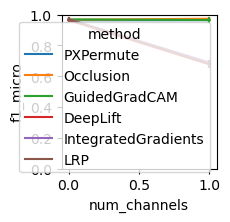

In [25]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(2,2))
ax = sns.lineplot(data = results_with_best_channels, 
            x = "num_channels", 
            y = "f1_micro",
                  hue="method",
                  err_style="bars",
                  errorbar=("se", 2),
                 ax=ax)

ax.set_ylim(0,1)

In [26]:
results_with_best_channels

,method,f1_micro,f1_macro,accuracy,fold_num,Ch0,Ch1,num_channels
0,PXPermute,0.969311,0.968548,0.969311,1,1,1,0
1,PXPermute,0.961149,0.960023,0.961149,2,1,1,0
2,PXPermute,0.965067,0.964111,0.965067,3,1,1,0
3,PXPermute,0.964740,0.963763,0.964740,4,1,1,0
4,PXPermute,0.956252,0.955040,0.956252,5,1,1,0
5,PXPermute,0.955926,0.954953,0.955926,1,0,1,1
6,PXPermute,0.958211,0.957172,0.958211,2,0,1,1
7,PXPermute,0.982697,0.982268,0.982697,3,0,1,1
8,PXPermute,0.960496,0.959577,0.960496,4,0,1,1
9,PXPermute,0.960496,0.959459,0.960496,5,0,1,1


In [27]:
results_with_best_channels.to_csv("results_with_best_channels_remove_bad_channels_and_retrain.csv", index = False)